In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root="../../Data/", train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.MNIST(root="../../Data", train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [27]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Dealing with gray scale image so the in_channels =1 here which is the first parameter
# 6 out_channels for the feature extraction these are known as feature map. So here there are 6 filters present
# Each filter of size 3*3, the stride is the step size
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
# 6 input filters in the input and the 16 filters will be there in the conv2D
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
for i, (x_train, y_train) in enumerate(train_data):
    break

In [11]:
x_train.shape

torch.Size([1, 28, 28])

In [13]:
x = x_train.view(1,1,28,28)#---- 4D batch (Batch of 1 image)
x.shape

torch.Size([1, 1, 28, 28])

In [15]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [16]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [32]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6,16, 3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [33]:
torch.manual_seed(42)
model = ConvolutionNetwork()
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(item)
    print(f"______\nSum : {sum(params)}")

count_parameters(model)

54
6
864
16
48000
120
10080
84
840
10
______
Sum : 60074


### Define loss and optimization

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    #Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        #Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        #Tally the nmber of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    #Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_pred = model(X_test)

            #Tally the number of predictions
            predicted = torch.max(y_pred.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_pred, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04055638  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08253469  accuracy:  85.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.36470169  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01825046  accuracy:  90.525%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00775025  accuracy:  91.660%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00110104  accuracy:  92.503%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.53726619  accuracy:  93.136%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.04146168  accuracy:  93.596%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01003017  accuracy:  94.009%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03305835  accuracy:  94.312%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.02725066  accuracy:  97.800%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.04815326  accuracy:  97.833%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00102998  accuracy:  97.883%
epoch:  1  b

#### Plot losses and accuracy comparision

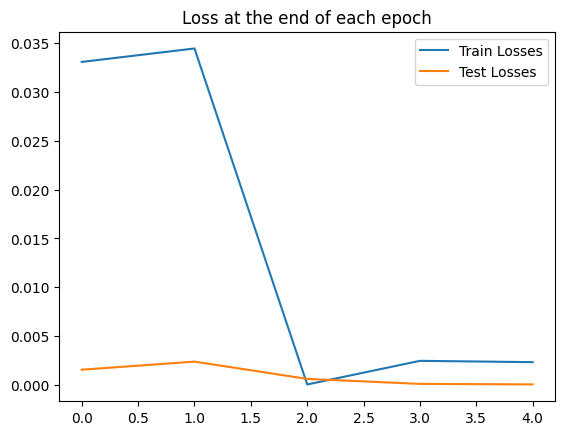

In [39]:
train_numpy_losses = [loss.detach().numpy() for loss in train_losses]
test_numpy_losses = [loss.detach().numpy() for loss in test_losses]
plt.plot(train_numpy_losses, label="Train Losses")
plt.plot(test_numpy_losses, label="Test Losses")
plt.title('Loss at the end of each epoch')
plt.legend()

In [38]:
test_numpy_losses

[array(0.00156018, dtype=float32),
 array(0.00238768, dtype=float32),
 array(0.00061846, dtype=float32),
 array(0.00010834, dtype=float32),
 array(5.5424804e-05, dtype=float32)]

In [40]:
train_correct

[tensor(56587), tensor(58810), tensor(59108), tensor(59338), tensor(59410)]

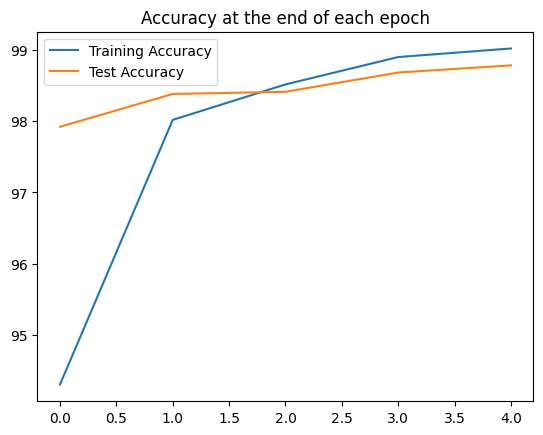

In [44]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Test Accuracy")
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [46]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=1000, shuffle=True)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
print(f"Test Accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%")

Test Accuracy: 9878/10000 =  98.780%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

#### Display the confusion matrix

In [59]:
print(predicted.shape)
print(y_test.shape)

torch.Size([1000])
torch.Size([1000])


In [60]:
# Print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

#Print the confusion matrix
print(confusion_matrix(predicted, y_test))

[[   0    1    2    3    4    5    6    7    8    9]]

[[  88    0    0    0    0    0    0    1    0    0]
 [   0  119    0    0    0    0    0    0    0    0]
 [   0    0   98    1    0    0    0    0    0    0]
 [   0    0    0  105    0    5    0    0    0    0]
 [   0    0    0    0  100    0    0    0    0    0]
 [   0    0    0    0    0   82    0    0    0    0]
 [   0    0    0    0    0    1   85    0    0    0]
 [   0    0    0    0    0    0    0  108    0    0]
 [   0    0    0    0    0    0    1    1   94    1]
 [   0    0    0    0    0    0    0    1    0  109]]


#### Examine the misses

In [62]:
predicted.shape

torch.Size([1000])

In [64]:
misses = np.array([])
for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype('int64')
    
len(misses)

12

In [65]:
misses[:10]

array([  62,  133,  139,  361,  553,  585,  640,  761,  853,  858])

In [99]:
# Set up an iterator to feed batched rows
r = 12 #Row size
row = iter(np.array_split(misses, len(misses)//r+1))

Index : [  62  133  139  361  553  585]
Label : [   5    5    7    6    5    7]
Guess : [   3    3    9    8    6    8]


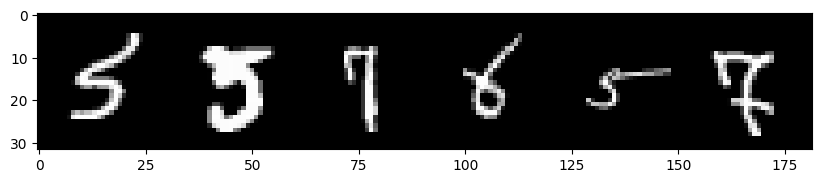

In [100]:
next_row = next(row)
print(f"Index : {next_row}")
print(f"Label : {y_test.index_select(0, torch.tensor(next_row)).numpy()}")
print(f"Guess : {predicted.index_select(0, torch.tensor(next_row)).numpy()}")

images = X_test.index_select(0, torch.tensor(next_row))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

In [116]:
test_data[2019][0].shape

torch.Size([1, 28, 28])

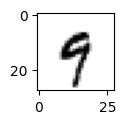

In [118]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg")

In [123]:
with torch.no_grad():
    res = model(test_data[x][0].view(1,1,28,28)).argmax()
print(f"Predicted value is this : {res.item()}")

Predicted value is this : 9
